# Multiple Author Detection Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from nltk import SnowballStemmer
import matplotlib.pyplot as plt
import time
import json
import os

%matplotlib inline

### Data Aggregation

The first step was to aggregate the data into a Pandas dataframe so that analysis could be performed.  Each of the three groups of data files (training, test, and validation sets) were parsed and combined into separate dataframes for each set.  The JSON files containing class labels were also parsed and joined to their respective text files creating three dataframes of two columns each.

In [2]:
def DataAggregator(path):
    """Reads in all files within a given folder path and builds a dataframe of two columns.
    The first column is the text and the second the labels identifying the text class."""
    text_dict = {}  #Create a dictionary of text files with the file number as the key
    json_dict = {}  #Create a dictionary of labels with the file number as the key
    label_df = pd.DataFrame(columns=['changes', 'positions','file'])

    for file in os.listdir(path):  #Scan through all files in the folder
        if file.endswith('.txt'):   #If the file contains text, append to text_dict
            with open(path+file, 'r', encoding='utf-8') as myfile:
                text_dict[file.replace('problem-', '').replace('.txt', '')] = myfile.read().replace('\n', '')  #Create the key
        else:   #If the file is JSON, add the label to json_dict
            with open(path+file, 'r', encoding='utf-8') as myfile:
                data = json.load(myfile)
                json_dict[file.replace('problem-', '').replace('.truth', '')] = data['changes']  #Create the key

    df = pd.DataFrame(list(text_dict.items()), columns=['file', 'text'])
    label_df = pd.DataFrame(list(json_dict.items()), columns = ['file', 'changes'])

    output_df = df.merge(label_df,on='file')  #Join the dataframes
    output_df = output_df.drop('file', axis = 1)  #Drop the file number column
    return output_df

In [4]:
#Convert the data sets to data frames
test_df = DataAggregator('C:/Users/RSC/Pyprojects/Data-Science/Data/pan18-style-change-detection-test-dataset-2018-01-31/')
training_df = DataAggregator('C:/Users/RSC/Pyprojects/Data-Science/Data/pan18-style-change-detection-training-dataset-2018-01-31/')
validation_df = DataAggregator('C:/Users/RSC/Pyprojects/Data-Science/Data/pan18-style-change-detection-validation-dataset-2018-01-31/')


In [5]:
#Split the data into text and labels
training_labels = training_df['changes']
validation_labels = validation_df['changes']
test_labels = test_df['changes']

training_text = training_df['text']
validation_text = validation_df['text']
test_text = test_df['text']

#Check that the dataframes are symmetric to test parse quality
print("Training Text: " + str(len(training_text)) + ", Training Labels: " + str(len(training_labels)))
print("Test Text: " + str(len(test_text)) + ", Test Labels: " + str(len(test_labels)))
print("Validation Text: " + str(len(validation_text)) + ", Validation Labels: " + str(len(validation_labels)))

Training Text: 2980, Training Labels: 2980
Test Text: 1352, Test Labels: 1352
Validation Text: 1492, Validation Labels: 1492


In [6]:
#Merge the training and validation sets into a new training set, as only a single training
#and test set are required for this analysis
new_train_text = training_text.append(validation_text)
new_train_labels = training_labels .append(validation_labels)
print("Training Text: " + str(len(new_train_text)) + ", Training Labels: " + str(len(new_train_labels)))

Training Text: 4472, Training Labels: 4472


### Parameter Testing

Before classification, a few hypotheses were tested to find parameters that allow for accurate classification.  The first is to test using n-grams of different sizes.  Single words are not expected to suffice as detecting multiple authors will heavily rely on different writing styles.

After testing n-gram sizes, a bag of word counts model is compared to a TF-IDF model.

In [7]:
#Test ngram size using a Multinomial Naive Bayes classifer
ngrams = [(1,1),(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)]

accuracy_count = []
accuracy_tfidf = []

clf = MultinomialNB()

for ngram in ngrams:
    X_train, X_test = train_test_split(training_df)
    vec = CountVectorizer(strip_accents = 'ascii', ngram_range = ngram, analyzer = 'word', stop_words='english')
    training_text = vec.fit_transform(X_train['text'])
    testing_text = vec.transform(X_test['text'])
    
    clf.fit(training_text, X_train['changes'])
    pred = clf.predict(testing_text)
    
    accuracy_count.append(metrics.accuracy_score(pred, X_test['changes']))
  
#Test if accuracy is improved using TF-IDF rather than word counts
for ngram in ngrams:
    X_train, X_test = train_test_split(training_df)
    vec = TfidfVectorizer(strip_accents = 'ascii', ngram_range = ngram, analyzer = 'word', stop_words='english')
    training_text = vec.fit_transform(X_train['text'])
    testing_text = vec.transform(X_test['text'])
    
    clf.fit(training_text, X_train['changes'])
    pred = clf.predict(testing_text)
    
    accuracy_tfidf.append(metrics.accuracy_score(pred, X_test['changes']))

In [8]:
print(accuracy_count)
print(accuracy_tfidf)

[0.68724832214765097, 0.65906040268456378, 0.66040268456375839, 0.62013422818791941, 0.6469798657718121, 0.64832214765100671, 0.66845637583892614, 0.68859060402684569, 0.64161073825503356, 0.67785234899328861]
[0.64563758389261749, 0.61342281879194627, 0.63087248322147649, 0.57449664429530201, 0.62550335570469795, 0.64026845637583896, 0.68724832214765097, 0.60134228187919458, 0.66711409395973154, 0.64026845637583896]


Using n-grams helps the accuracy of the classifier and there isn't a significant difference between the models.

Next, test whether stemming the words helps classification.

In [19]:
stemmer = SnowballStemmer('english')

X_train, X_test = train_test_split(training_df)
vec = TfidfVectorizer(tokenizer=stemmer.stem, strip_accents = 'ascii', ngram_range=(1,3), analyzer='word', stop_words='english')
stemmed_train_text = vec.fit_transform(X_train['text'])
stemmed_test_text = vec.transform(X_test['text'])

clf = MultinomialNB()

clf.fit(stemmed_train_text, X_train['changes'])
pred = clf.predict(stemmed_test_text)

print(metrics.accuracy_score(pred, X_test['changes']))

0.480536912752


Stemming words causes a large drop in accuracy, likely due to masking writing style when multiple authors are involved.  This causes classification to only be dependant on word choice, which isn't a strong predictor without specific author labels.

### Data Preprocessing

After identifying pre-processing conditions for analysis, 4 algorithms are tested.  They are Bernoulli Naive Bayes, Multinomial Naive bayes, Support Vector, and K-Nearest Neighbor classifiers.

In [10]:
#Build data pipelines
NB_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', BernoulliNB())])

MNB_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultinomialNB())])

SVC_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SVC(C=0.5, probability=True))])

KNN_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', KNeighborsClassifier(10))])


### Testing Classifiers

After creating the classifier objects, all algorithms are trained on the combined training and validation data, and tested on the test set.  Below are accuracy scores and the associated confusion matrices.

In [11]:
#Train the models and fit to the validation set, starting with Bernoulli Naive Bayes
start = time.time() #Track the run time
nb_proba = NB_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text) #Fit the model
nb_prediction = NB_pipeline.predict(test_text)  #Predict class labels on test set
print("Bernoulli Naive Bayes Accuracy: " + str(metrics.accuracy_score(nb_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
nb_confusion = metrics.confusion_matrix(test_labels, nb_prediction) #Generate a confusion matrix
print(nb_confusion)


Bernoulli Naive Bayes Accuracy: 0.906804733728 -- Run time 40.52743124961853
[[593  83]
 [ 43 633]]


In [20]:
#Fit a Multinomial Naive Bayes model
start = time.time()
mnb_proba = MNB_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
mnb_prediction = MNB_pipeline.predict(test_text)#Predict class labels on test set
print("Multinomial Naive Bayes Accuracy: " + str(metrics.accuracy_score(mnb_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
mnb_confusion = metrics.confusion_matrix(test_labels, mnb_prediction) #Generate a confusion matrix
print(nb_confusion)


Multinomial Naive Bayes Accuracy: 0.546597633136 -- Run time 44.72029685974121
[[593  83]
 [ 43 633]]


In [13]:
#Fit a Support Vector Classifier
start = time.time()
svc_proba = SVC_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
svc_prediction = SVC_pipeline.predict(test_text)#Predict class labels on test set
print("SVC Accuracy: " + str(metrics.accuracy_score(svc_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
svc_confusion = metrics.confusion_matrix(test_labels, svc_prediction)#Generate a confusion matrix
print(svc_confusion)

SVC Accuracy: 0.616124260355 -- Run time 837.6055936813354
[[595  81]
 [438 238]]


In [14]:
#Fit a K-Nearest Neighbor Classifier
start = time.time()
knn_proba = KNN_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
knn_prediction = KNN_pipeline.predict(test_text)#Predict class labels on test set
print("KNN Accuracy: " + str(metrics.accuracy_score(knn_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
knn_confusion = metrics.confusion_matrix(test_labels, knn_prediction)#Generate a confusion matrix
print(knn_confusion)

KNN Accuracy: 0.619082840237 -- Run time 44.92830681800842
[[247 429]
 [ 86 590]]


### Results

The best results are from the Bernoulli Naive Bayes approach with ~90% accuracy.  The bar graph below summarizes all classifier accuracy scores.

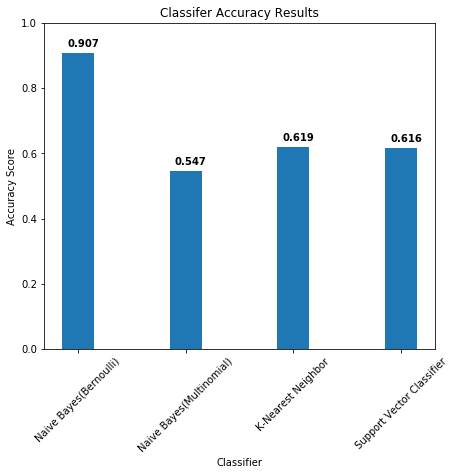

In [15]:
labels = ['Naive Bayes(Bernoulli)', 'Naive Bayes(Multinomial)', 'K-Nearest Neighbor', 'Support Vector Classifier']

#Get all accuracy scores
nb_acc = metrics.accuracy_score(nb_prediction, test_labels)
mnb_acc = metrics.accuracy_score(mnb_prediction, test_labels)
knn_acc = metrics.accuracy_score(knn_prediction, test_labels)
svc_acc = metrics.accuracy_score(svc_prediction, test_labels)

values = [nb_acc, mnb_acc, knn_acc, svc_acc]

#Create a bar graph
fix, ax = plt.subplots(figsize=(7,6))
ax.bar(np.arange(4), height=values, width = 0.3)
ax.set_xticklabels(labels, rotation=45)
ax.set_xticks(np.arange(4))
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Classifier')
ax.set_ylim(0,1)

#Add bar y values
for i, v in enumerate(values):
    ax.text(i-.1, v+0.02, '%.3f' % v, fontweight ='bold')

ax.set_title('Classifer Accuracy Results')



The accuracy results can also be seen in the confusion matrix for each classifier.  All confusion matrices are summarized below.  Interestingly, they all had a different problem in attempting to classify the data.  The multinomial model almost exclusively assigned the text instances to the same class, as shown by having an almost equal amount of false positives as true positives.  The K-Nearest Neighbor classifier had a high rate of false positives while the support vector classifier showed a high rate of false negatives.

In [16]:
columns = ['TN', 'FP', 'FN', 'TP']

#Get all metrics from each algorithm's confusion matrix
confusion = [[nb_confusion[0][0], nb_confusion[0][1], nb_confusion[1][0], nb_confusion[1][1]],
             [mnb_confusion[0][0], mnb_confusion[0][1], mnb_confusion[1][0], mnb_confusion[1][1]],
       [knn_confusion[0][0], knn_confusion[0][1], knn_confusion[1][0], knn_confusion[1][1]],
       [svc_confusion[0][0], svc_confusion[0][1], svc_confusion[1][0], svc_confusion[1][1]]]

df = pd.DataFrame(data = confusion, columns = columns, index = labels)

#Print the confusion matrix
print("Confusion Matrix Summary")
print(df)

Confusion Matrix Summary
                            TN   FP   FN   TP
Naive Bayes(Bernoulli)     593   83   43  633
Naive Bayes(Multinomial)    67  609    4  672
K-Nearest Neighbor         247  429   86  590
Support Vector Classifier  595   81  438  238


Another way to view the results is using precision, recall and the f1-score.  The low precision and high recall of the multinomial naive bayes model again indicates it tends to confuse the classes and result in a high amount of false positives.  The k-nearest neighbor and support vector classifiers also maintain their trend of high false positives and false negatives respectively.

In [17]:
#Print precision, recall and f1-scores with support
print('----------------Naive Bayes (Bernoulli)----------------')
print(metrics.classification_report(nb_prediction, test_labels))
print('---------------Naive Bayes (Multinomial)---------------')
print(metrics.classification_report(mnb_prediction, test_labels))
print('-------------------K-Nearest Neighbor-------------------')
print(metrics.classification_report(knn_prediction, test_labels))
print('----------------Support Vector Classifier----------------')
print(metrics.classification_report(svc_prediction, test_labels))

----------------Naive Bayes (Bernoulli)----------------
             precision    recall  f1-score   support

      False       0.88      0.93      0.90       636
       True       0.94      0.88      0.91       716

avg / total       0.91      0.91      0.91      1352

---------------Naive Bayes (Multinomial)---------------
             precision    recall  f1-score   support

      False       0.10      0.94      0.18        71
       True       0.99      0.52      0.69      1281

avg / total       0.95      0.55      0.66      1352

-------------------K-Nearest Neighbor-------------------
             precision    recall  f1-score   support

      False       0.37      0.74      0.49       333
       True       0.87      0.58      0.70      1019

avg / total       0.75      0.62      0.65      1352

----------------Support Vector Classifier----------------
             precision    recall  f1-score   support

      False       0.88      0.58      0.70      1033
       True       0.3

Finall, the ROC curves are consistent with the previous evaluation metrics.  

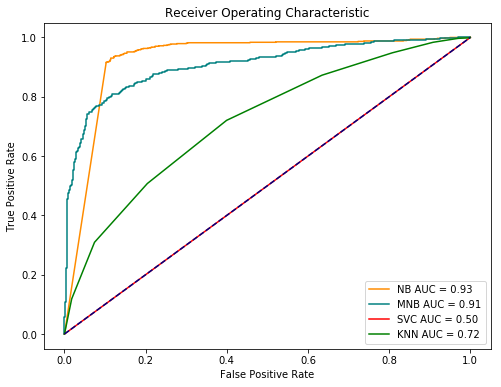

In [18]:
#Generate ROC curves and calculate auc values
nb_fpr, nb_tpr, __ = metrics.roc_curve(test_labels, nb_proba[:,1])
nb_auc = metrics.auc(nb_fpr, nb_tpr)
mnb_fpr, mnb_tpr, __ = metrics.roc_curve(test_labels, mnb_proba[:,1])
mnb_auc = metrics.auc(mnb_fpr, mnb_tpr)
svc_fpr, svc_tpr, __ = metrics.roc_curve(test_labels, svc_proba[:,1])
svc_auc = metrics.auc(svc_fpr, svc_tpr)
knn_fpr, knn_tpr, __ = metrics.roc_curve(test_labels, knn_proba[:,1])
knn_auc = metrics.auc(knn_fpr, knn_tpr)

#Plot the ROC curves
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.plot(nb_fpr, nb_tpr, color='darkorange', label='NB AUC = %0.2f' %nb_auc)
ax.plot(mnb_fpr, mnb_tpr, color='teal', label='MNB AUC = %0.2f' %mnb_auc)
ax.plot(svc_fpr, svc_tpr, color = 'red', label='SVC AUC = %0.2f' %svc_auc)
ax.plot(knn_fpr, knn_tpr, color = 'green', label = 'KNN AUC = %0.2f' %knn_auc)
ax.plot([0,1], [0,1], 'r--', color='navy')

ax.legend(loc="lower right")


plt.show()